## Import Libraries

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras as keras

# Constants
CANVAS_SIZE = 28  # Output rasterized image size (28x28)
NUM_EXAMPLES_PER_DIGIT = 30
NUM_CLASSES = 10  # Digits 0-9

## Data Loading and Preparation

First, we need to extract and parse the JSON files from the dataset.

In [ ]:
# Set this to data directory

!unzip /content/EEP564_HW2_Data.zip -d /content/
DATA_DIR = "./EEP564_HW2_Data"

def load_and_parse_json_files():
    """
    Load and parse all JSON files in the data directory.
    Returns a dictionary with digit labels as keys and lists of examples as values.
    """
    digit_examples = {str(i): [] for i in range(10)}

    # List all JSON files in the data directory
    json_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.json')]

    for json_file in json_files:
        file_path = os.path.join(DATA_DIR, json_file)

        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

                # Each file is a dictionary with a 'strokes' key
                # The 'strokes' key contains a list of examples
                if 'strokes' in data and isinstance(data['strokes'], list):
                    for example in data['strokes']:
                        if isinstance(example, dict):
                            label = example.get('label')
                            stroke_points = example.get('strokePoints', [])

                            if label is not None and stroke_points and label in digit_examples:
                                digit_examples[label].append(stroke_points)
        except Exception as e:
            print(f"Error processing file {json_file}: {e}")

    # Print statistics about the dataset
    for digit, examples in digit_examples.items():
        print(f"Digit {digit}: {len(examples)} examples")

    return digit_examples

Archive:  /content/EEP564_HW2_Data.zip
replace /content/EEP564_HW2_Data/AaronSong-0.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/EEP564_HW2_Data/AaronSong-0.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-1.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-2.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-3.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-4.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-5.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-6.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-7.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-8.json  
  inflating: /content/EEP564_HW2_Data/AaronSong-9.json  
  inflating: /content/EEP564_HW2_Data/Anchor-0.json  
  inflating: /content/EEP564_HW2_Data/Anchor-1.json  
  inflating: /content/EEP564_HW2_Data/Anchor-2.json  
  inflating: /content/EEP564_HW2_Data/Anchor-3.json  
  inflating: /content/EEP564_HW2_Data/Anchor-4.json  
  inflating: /content/EEP564_H

## Rasterization Function

This function converts stroke points to rasterized images.

In [ ]:
def rasterize_stroke_points(stroke_points, canvas_size=CANVAS_SIZE):
    """
    Convert stroke points to a rasterized image.

    Args:
        stroke_points: List of (x, y) coordinates
        canvas_size: Size of the output canvas (square)

    Returns:
        A numpy array of shape (canvas_size, canvas_size) with the rasterized digit
    """
    # Create an empty canvas
    canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)

    # Normalize coordinates to canvas size
    # The original coordinates are in range [-1, 1], we need to map to [0, canvas_size-1]
    for point in stroke_points:
        x, y = point['x'], point['y']

        # Map from [-1, 1] to [0, canvas_size-1]
        pixel_x = int((x + 1) * (canvas_size - 1) / 2)
        pixel_y = int((y + 1) * (canvas_size - 1) / 2)

        # Ensure coordinates are within canvas bounds
        pixel_x = max(0, min(pixel_x, canvas_size - 1))
        pixel_y = max(0, min(pixel_y, canvas_size - 1))

        # Set the pixel value to 1 (white)
        canvas[pixel_y, pixel_x] = 1.0

    return canvas

## Dataset Preparation

Prepare a dataset with 30 examples per digit (0-9).

In [ ]:
def prepare_dataset():
    """
    Prepare a dataset with 30 examples per digit (0-9).

    Returns:
        X: numpy array of shape (300, 28, 28, 1) - rasterized images
        y: numpy array of shape (300, 10) - one-hot encoded labels
    """
    # Load and parse JSON files
    digit_examples = load_and_parse_json_files()

    # Prepare arrays for data and labels
    X = []
    y = []

    # For each digit (0-9)
    for digit in range(10):
        digit_str = str(digit)
        examples = digit_examples.get(digit_str, [])

        # Ensure we have at least 30 examples per digit
        if len(examples) < NUM_EXAMPLES_PER_DIGIT:
            print(f"Warning: Only {len(examples)} examples found for digit {digit}. Need {NUM_EXAMPLES_PER_DIGIT}.")
            # If we don't have enough examples, we'll use what we have and duplicate some
            if len(examples) > 0:  # Avoid division by zero
                examples = examples * (NUM_EXAMPLES_PER_DIGIT // len(examples) + 1)
            else:
                print(f"Error: No examples found for digit {digit}. Skipping.")
                continue

        # Select 30 examples for this digit
        selected_examples = examples[:NUM_EXAMPLES_PER_DIGIT]

        # Rasterize each example and add to dataset
        for example in selected_examples:
            rasterized = rasterize_stroke_points(example)
            X.append(rasterized)
            y.append(digit)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Reshape X to include channel dimension: (300, 28, 28) -> (300, 28, 28, 1)
    X = X.reshape(-1, CANVAS_SIZE, CANVAS_SIZE, 1)

    # Convert labels to one-hot encoding (categorical) to match the model's output
    y_categorical = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

    return X, y_categorical

# Prepare the dataset
print("Preparing dataset...")
X, y = prepare_dataset()
print(f"Dataset prepared: {X.shape}, {y.shape}")

Preparing dataset...
Digit 0: 24 examples
Digit 1: 23 examples
Digit 2: 18 examples
Digit 3: 19 examples
Digit 4: 17 examples
Digit 5: 20 examples
Digit 6: 21 examples
Digit 7: 20 examples
Digit 8: 20 examples
Digit 9: 21 examples
Dataset prepared: (300, 28, 28, 1), (300, 10)


## Visualization

Randomly select 1 example per class (0-9) and visualize them.

Visualizing examples...


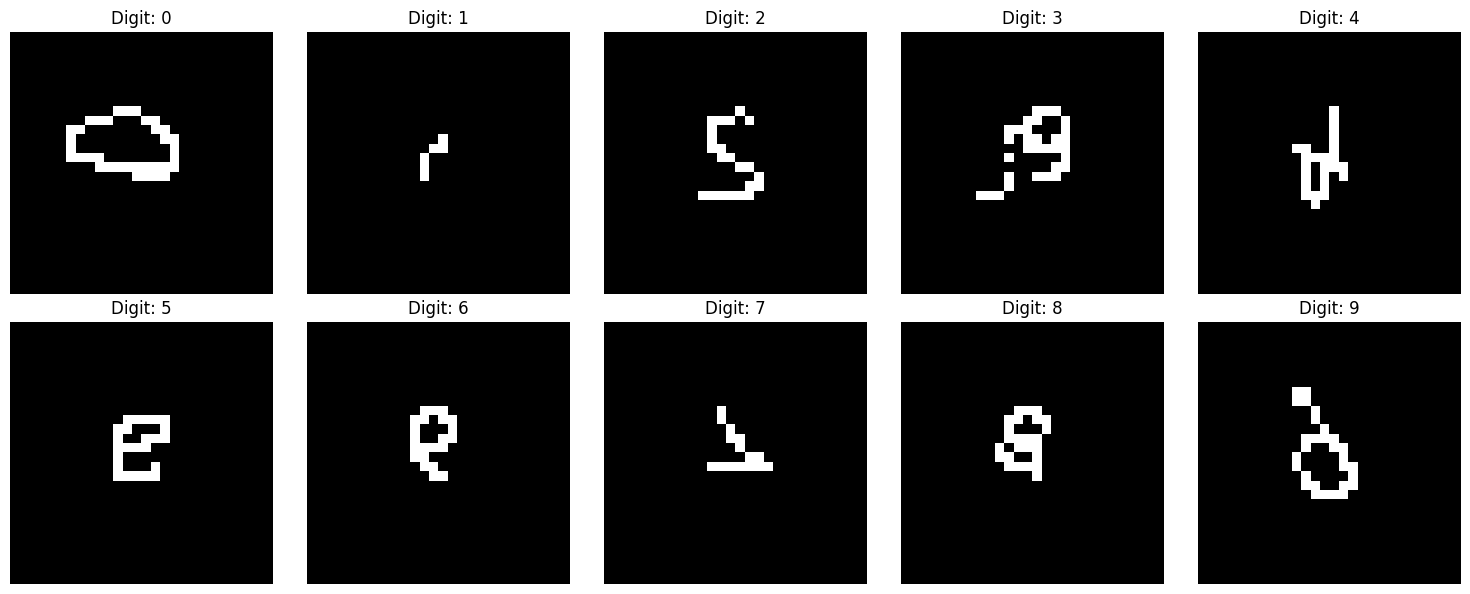

In [ ]:
def visualize_examples(X, y):
    """
    Randomly select 1 example per class (0-9) and visualize them.

    Args:
        X: numpy array of shape (n_samples, 28, 28, 1) - rasterized images
        y: numpy array of shape (n_samples, 10) - one-hot encoded labels
    """
    # Convert one-hot encoded labels back to integers for easier handling
    y_indices = np.argmax(y, axis=1)

    # Create a figure with 10 subplots (1 per digit)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # For each digit (0-9)
    for digit in range(10):
        # Find all examples of this digit
        digit_indices = np.where(y_indices == digit)[0]

        if len(digit_indices) == 0:
            print(f"Warning: No examples found for digit {digit}. Skipping visualization.")
            axes[digit].text(0.5, 0.5, f"No examples for digit {digit}",
                            horizontalalignment='center', verticalalignment='center')
            axes[digit].set_title(f'Digit: {digit} (missing)')
            axes[digit].axis('off')
            continue

        # Convert numpy array to list for random.choice
        digit_indices_list = digit_indices.tolist()

        # Randomly select one example
        random_idx = random.choice(digit_indices_list)

        # Get the image
        img = X[random_idx, :, :, 0]  # Remove channel dimension

        # Plot the image
        axes[digit].imshow(img, cmap='gray')
        axes[digit].set_title(f'Digit: {digit}')
        axes[digit].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize examples
print("Visualizing examples...")
visualize_examples(X, y)

## Model Architecture

Define the model architecture as in Lab 6.

In [ ]:
def make_model(input_shape, num_classes):
    """
    Create the model architecture as defined in Lab 6.

    Args:
        input_shape: Shape of the input images
        num_classes: Number of output classes

    Returns:
        A Keras model
    """
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

## Load and Fine-tune Model

Load the model from Lab 6 (or create a new one with the same architecture if not available), freeze all layers except the final Dense layer, and fine-tune it on our dataset.

In [ ]:
def load_and_fine_tune_model(X, y):
    """
    Load the model from Lab 6, freeze all layers except the final Dense layer,
    and fine-tune it on the dataset.

    Args:
        X: numpy array of shape (n_samples, 28, 28, 1) - rasterized images
        y: numpy array of shape (n_samples, 10) - one-hot encoded labels

    Returns:
        The fine-tuned model
    """
    try:
        # Try to load the saved model from Lab 6
        model = keras.models.load_model('model.keras')
        print("Successfully loaded model.keras from Lab 6")
    except:
        # If the model file is not found, create a new model with the same architecture
        print("Warning: model.keras not found. Creating a new model with the Lab 6 architecture.")
        model = make_model(input_shape=(28, 28, 1), num_classes=10)
        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

    # Print model summary
    model.summary()

    # Freeze all layers except the final Dense layer
    for layer in model.layers[:-1]:
        layer.trainable = False

    # Ensure the final layer is trainable
    model.layers[-1].trainable = True

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fine-tune the model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val)
    )

    return model

# Load and fine-tune the model
print("Loading and fine-tuning model...")
model = load_and_fine_tune_model(X, y)

Loading and fine-tuning model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,394 (95.29 KB)

 Trainable params: 24,170 (94.41 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0750 - loss: 2.3026 - val_accuracy: 0.0500 - val_loss: 2.3040
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1133 - loss: 2.3025 - val_accuracy: 0.0333 - val_loss: 2.3045
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1414 - loss: 2.3018 - val_accuracy: 0.0333 - val_loss: 2.3053
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1260 - loss: 2.3014 - val_accuracy: 0.0333 - val_loss: 2.3061
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1130 - loss: 2.3023 - val_accuracy: 0.0333 - val_loss: 2.3068
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1069 - loss: 2.3016 - val_accuracy: 0.0333 - val_loss: 2.3075
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1425 - loss: 2.3006 - val_accuracy: 0.0333 - val_loss: 2.3084
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1032 - loss: 2.3017 - val_accuracy: 0.0333 - val_loss: 2.3089


## Evaluate Model

Evaluate the fine-tuned model and generate a classification report.

In [ ]:
def evaluate_model(model, X, y):
    """
    Evaluate the model on the dataset and print the classification report.

    Args:
        model: The fine-tuned model
        X: numpy array of shape (n_samples, 28, 28, 1) - rasterized images
        y: numpy array of shape (n_samples, 10) - one-hot encoded labels
    """
    # Predict classes
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y, axis=1)

    # Print classification report
    report = classification_report(y_true_classes, y_pred_classes)
    print(report)

    return report

# Evaluate the model
print("Evaluating model...")
report = evaluate_model(model, X, y)

Evaluating model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        30
           4       0.10      1.00      0.18        30
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        30
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00        30

    accuracy                           0.10       300
   macro avg       0.01      0.10      0.02       300
weighted avg       0.01      0.10      0.02       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Save the Fine-tuned Model

Save the fine-tuned model for later use in Arduino deployment.

In [ ]:
# Save the fine-tuned model
model.save('fine_tuned_model.keras')
print("Fine-tuned model saved to fine_tuned_model.keras")


Fine-tuned model saved to fine_tuned_model.keras


In [ ]:
model = tf.keras.models.load_model('fine_tuned_model.keras')
# Convert with int8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]

# Representative dataset with correct input shape
def representative_dataset():
    # Your model expects (batch_size, 28, 28, 1) - MNIST-like images
    for _ in range(100):
        # Generate random data matching your input shape
        yield [np.random.random((1, 28, 28, 1)).astype(np.float32)]

converter.representative_dataset = representative_dataset
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert
tflite_model_int8 = converter.convert()

# Save
with open('model_int8.tflite', 'wb') as f:
    f.write(tflite_model_int8)

print("Int8 quantized model saved successfully!")

Saved artifact at '/tmp/tmp6b_1rle0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  131967269163024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967269165328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163098768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163099152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163090320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163099344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163090704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163096080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163095888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967163096656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13196716309838

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
